# German Credit Data Classification
[credit_g](https://www.openml.org/d/31) dataset classifies people described by a set of attributes as good or bad credit risks. The dataset includes several features like age, employment, credit history, savings status etc. In this exercise, we'll merely focus on three classification algorithms 
1. K nearest neighbors
2. Logistic Regression
3. Linaer SVM
And to keep things simple, accuracy would be used as evaluation metric

This exercise is a part of Homework 2 of open source [applied ML course taught by Andreas Mueller](https://www.cs.columbia.edu/~amueller/comsw4995s20/schedule/).


In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [50]:
import warnings
warnings.filterwarnings('default')
warnings.filterwarnings('ignore', category=sklearn.exceptions.ConvergenceWarning)

## Importing the dataset 

In [3]:
data = datasets.fetch_openml('credit-g') # returns a dictionry (scikitlearn bunch)

In [4]:
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
print(data.DESCR)

**Author**: Dr. Hans Hofmann  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

**German Credit data**  
This dataset classifies people described by a set of attributes as good or bad credit risks.

This dataset comes with a cost matrix: 
``` 
      Good  Bad (predicted)  
Good   0    1   (actual)  
Bad    5    0  
```

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).  

### Attribute description  

1. Status of existing checking account, in Deutsche Mark.  
2. Duration in months  
3. Credit history (credits taken, paid back duly, delays, critical accounts)  
4. Purpose of the credit (car, television,...)  
5. Credit amount  
6. Status of savings account/bonds, in Deutsche Mark.  
7. Present employment, in number of years.  
8. Installment rate in percentage of disposable income  
9. Pe

In [6]:
def bunch_to_df(sklearn_bunch):
    '''
    function to covert scikit learn dataset (bunch) to pandas dataframe
    '''
    df = pd.DataFrame(data=sklearn_bunch['data'], columns=sklearn_bunch['feature_names']) # dataframe of features
    df['target'] = pd.Series(sklearn_bunch['target']) # add the targets/labels column
    return df

In [7]:
df = bunch_to_df(data)

In [8]:
df_orig = df.copy() # for further reference

In [9]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,0.0,6.0,4.0,3.0,1169.0,4.0,4.0,4.0,2.0,0.0,...,0.0,67.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,good
1,1.0,48.0,2.0,3.0,5951.0,0.0,2.0,2.0,1.0,0.0,...,0.0,22.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,bad
2,3.0,12.0,4.0,6.0,2096.0,0.0,3.0,2.0,2.0,0.0,...,0.0,49.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,good
3,0.0,42.0,2.0,2.0,7882.0,0.0,3.0,2.0,2.0,2.0,...,1.0,45.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,good
4,0.0,24.0,3.0,0.0,4870.0,0.0,2.0,3.0,2.0,0.0,...,3.0,53.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,bad


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   float64
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   float64
 3   purpose                 1000 non-null   float64
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   float64
 6   employment              1000 non-null   float64
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   float64
 9   other_parties           1000 non-null   float64
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   float64
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   float64
 14  housing                 1000 non-null   f

In [11]:
df.describe()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.577000,20.903000,2.54500,2.828000,3271.258000,1.105000,2.384000,2.973000,1.68200,0.145000,2.845000,1.358000,35.546000,1.675000,0.929000,1.407000,1.904000,1.155000,0.404000,0.037000
std,1.257638,12.058814,1.08312,2.744439,2822.736876,1.580023,1.208306,1.118715,0.70808,0.477706,1.103718,1.050209,11.375469,0.705601,0.531264,0.577654,0.653614,0.362086,0.490943,0.188856
min,0.000000,4.000000,0.00000,0.000000,250.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,19.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,12.000000,2.00000,1.000000,1365.500000,0.000000,2.000000,2.000000,1.00000,0.000000,2.000000,0.000000,27.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000
50%,1.000000,18.000000,2.00000,2.000000,2319.500000,0.000000,2.000000,3.000000,2.00000,0.000000,3.000000,1.000000,33.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000
75%,3.000000,24.000000,4.00000,3.000000,3972.250000,2.000000,4.000000,4.000000,2.00000,0.000000,4.000000,2.000000,42.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
max,3.000000,72.000000,4.00000,10.000000,18424.000000,4.000000,4.000000,4.000000,3.00000,2.000000,4.000000,3.000000,75.000000,2.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000


### Comment
It is important to note that original dataset had some categorical fields but data attribute of sklearn databunch include them in ordinal encoding form. We need to see the .categorical_features attributes of sklearn databunch to see which variables were categorical

## Data Processing 

### Task 1.1: Determine which features are continuous and which are categorical. 

In [12]:
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [13]:
all_features = data.feature_names
print(all_features)

['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker']


In [14]:
categorical_features = list(data.categories.keys()) # categorical features
print(categorical_features) 

['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [18]:
continuous_features = [x for x in all_features if x not in categorical_features] 
print(continuous_features) 

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']


### Task 1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target.

In [19]:
sns.distributions._has_statsmodels = False # to use scipy instead of statsmodels(giving error) for kde estimation

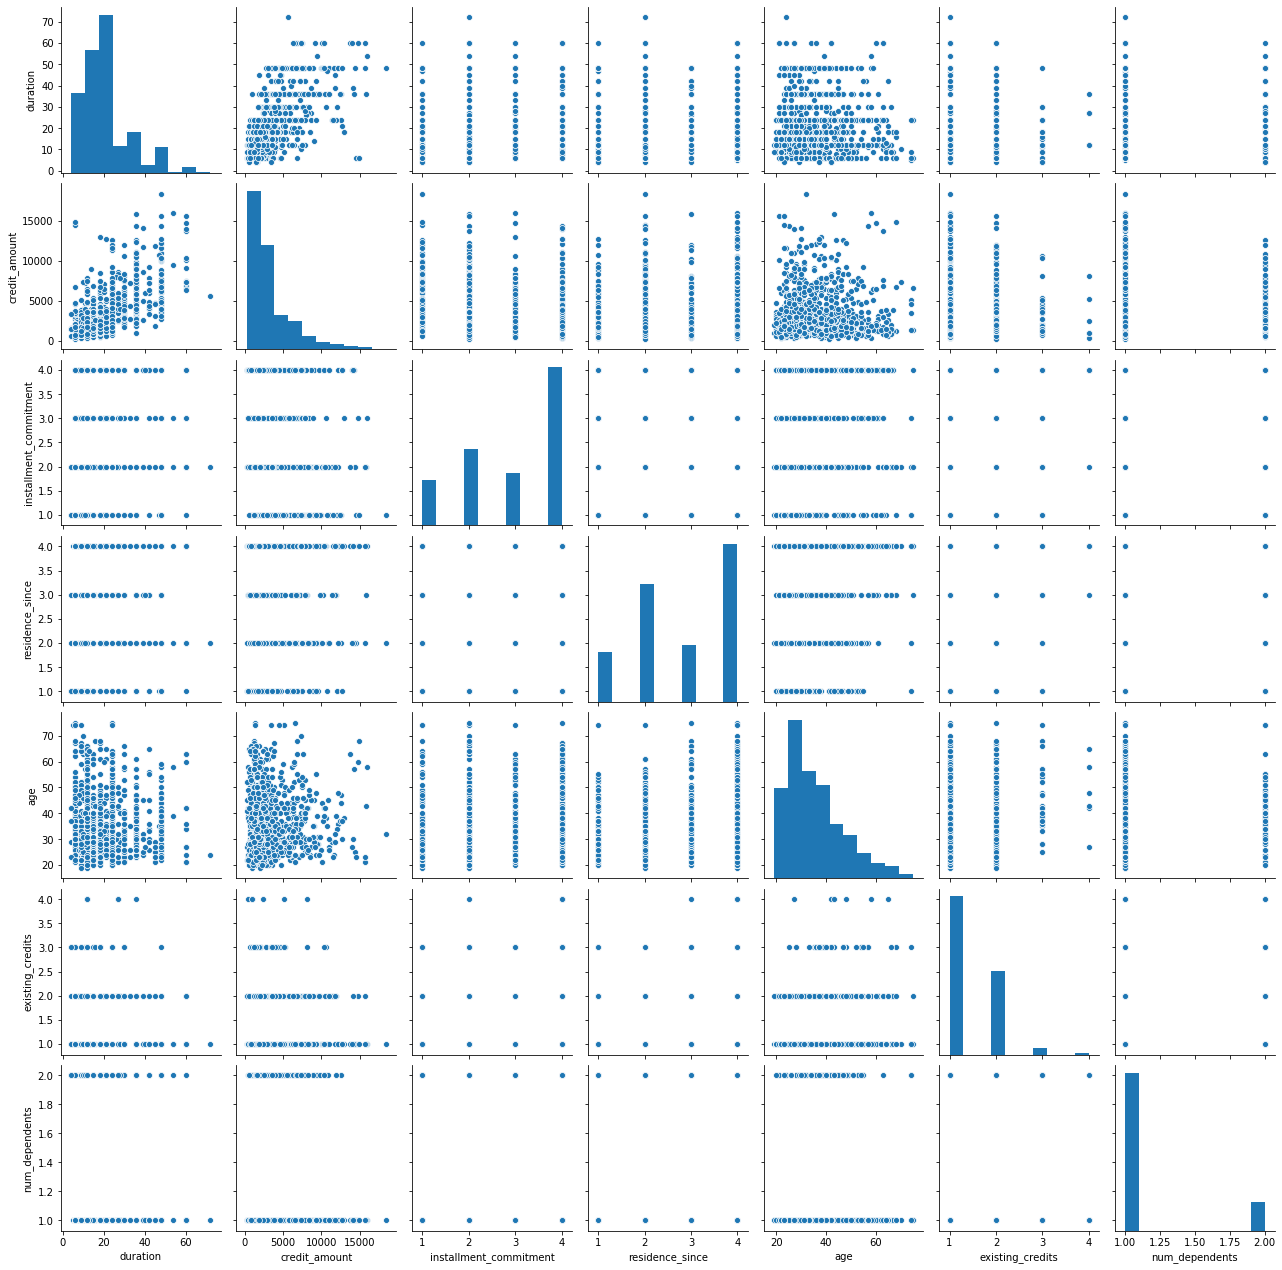

In [20]:
sns.pairplot(df, vars=continuous_features)
# the diagonal shows univariate distribution of all these continuous features

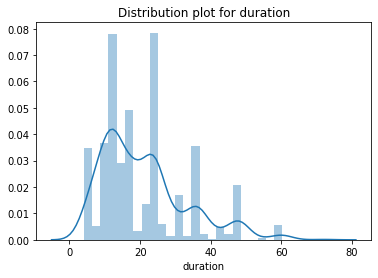

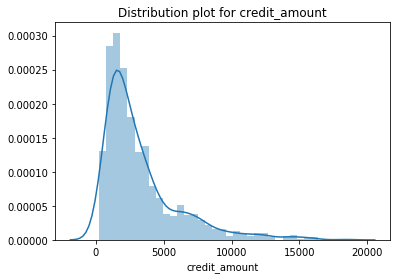

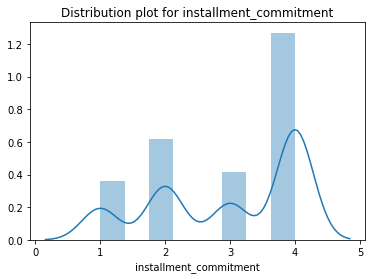

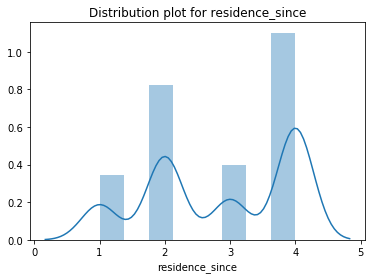

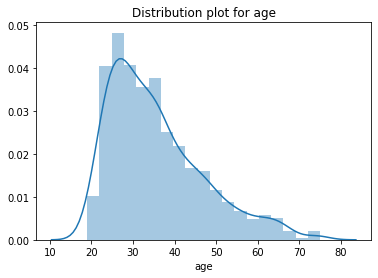

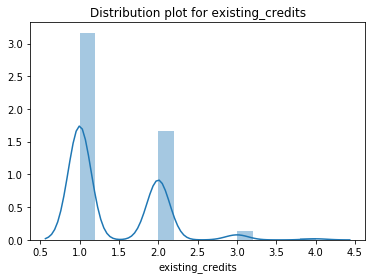

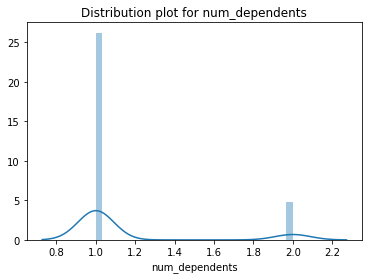

In [21]:
# to visualize distributions individually
for key in continuous_features:
    sns.distplot(df[key])
    plt.title('Distribution plot for {}'.format(key))
    plt.pause(0.001)

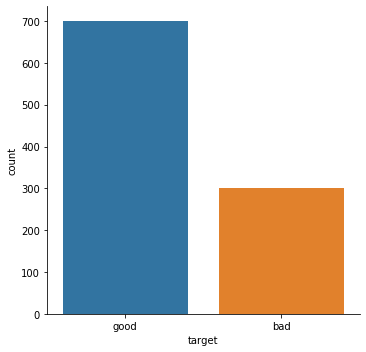

In [22]:
# catplot is used for categorical variables plotting in searborn
sns.catplot(x='target', data=df, kind='count')

### Comment 
it is an unbalanced dataset with 70:30 ratio and a naive classification model that predicts everything as good should give accuracy of 70% so be careful (using auc-roc or pr-curve would be better, however to keep things simple we will go with accuracy here)

### Task 1.3 Split data into training and test set. Do not use the test set until a final evaluation in 1.5. Preprocess the data (such as treatment of categorical variables) without using a pipeline and evaluate an initial LogisticRegression model with an training/validation split. 

In [27]:
#sklearn always treats data and targets independantly, so it is good practice to separate them
trainVal_df = df[df.keys().drop('target')].values
test_df = df['target'].values
x_trainVal, x_test, y_trainVal, y_test = train_test_split(trainVal_df, test_df)

In [30]:
#train-val split
x_train, x_val, y_train, y_val = train_test_split(x_trainVal, y_trainVal)
print('train set:  features: ', x_train.shape, 'labels: ', y_train.shape)
print('valid set:  features: ', x_val.shape, 'labels: ', y_val.shape)
print('Test  set:  features: ', x_test.shape, 'labels: ', y_test.shape)

train set:  features:  (562, 20) labels:  (562,)
valid set:  features:  (188, 20) labels:  (188,)
Test  set:  features:  (250, 20) labels:  (250,)


### Lets try one hot categorical encoding
previously data was ordinally coded

In [32]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,0.0,6.0,4.0,3.0,1169.0,4.0,4.0,4.0,2.0,0.0,...,0.0,67.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,good
1,1.0,48.0,2.0,3.0,5951.0,0.0,2.0,2.0,1.0,0.0,...,0.0,22.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,bad
2,3.0,12.0,4.0,6.0,2096.0,0.0,3.0,2.0,2.0,0.0,...,0.0,49.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,good
3,0.0,42.0,2.0,2.0,7882.0,0.0,3.0,2.0,2.0,2.0,...,1.0,45.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,good
4,0.0,24.0,3.0,0.0,4870.0,0.0,2.0,3.0,2.0,0.0,...,3.0,53.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,bad


In [34]:
df = pd.get_dummies(df, columns=categorical_features)
df.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,target,checking_status_0.0,checking_status_1.0,...,housing_1.0,housing_2.0,job_0.0,job_1.0,job_2.0,job_3.0,own_telephone_0.0,own_telephone_1.0,foreign_worker_0.0,foreign_worker_1.0
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,good,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,bad,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,good,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,good,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,bad,1,0,...,0,1,0,0,1,0,1,0,1,0


In [35]:
df.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,target,checking_status_0.0,checking_status_1.0,...,housing_1.0,housing_2.0,job_0.0,job_1.0,job_2.0,job_3.0,own_telephone_0.0,own_telephone_1.0,foreign_worker_0.0,foreign_worker_1.0
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,good,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,bad,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,good,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,good,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,bad,1,0,...,0,1,0,0,1,0,1,0,1,0


### Applying logistic regression to one hot encoded data

In [38]:
df.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,target,checking_status_0.0,checking_status_1.0,...,housing_1.0,housing_2.0,job_0.0,job_1.0,job_2.0,job_3.0,own_telephone_0.0,own_telephone_1.0,foreign_worker_0.0,foreign_worker_1.0
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,good,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,bad,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,good,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,good,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,bad,1,0,...,0,1,0,0,1,0,1,0,1,0


In [42]:
data_df, targets_df = df[df.keys().drop('target')], df['target'] # target column isn't always last one

In [43]:
# train(including valid)-test split
x_trainVal, x_test, y_trainVal, y_test = train_test_split(data_df, targets_df) # split 75:25
#train-val split
x_train, x_val, y_train, y_val = train_test_split(x_trainVal, y_trainVal)
print('train set:  features: ', x_train.shape, 'labels: ', y_train.shape)
print('valid set:  features: ', x_val.shape, 'labels: ', y_val.shape)
print('Test  set:  features: ', x_test.shape, 'labels: ', y_test.shape)
# we could also use panda slicing to do it manually

train set:  features:  (562, 61) labels:  (562,)
valid set:  features:  (188, 61) labels:  (188,)
Test  set:  features:  (250, 61) labels:  (250,)


In [44]:
x_train.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_0.0,checking_status_1.0,checking_status_2.0,...,housing_1.0,housing_2.0,job_0.0,job_1.0,job_2.0,job_3.0,own_telephone_0.0,own_telephone_1.0,foreign_worker_0.0,foreign_worker_1.0
307,12.0,727.0,4.0,3.0,33.0,1.0,1.0,1,0,0,...,1,0,0,1,0,0,0,1,1,0
329,6.0,1068.0,4.0,4.0,28.0,1.0,2.0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
304,48.0,10127.0,2.0,2.0,44.0,1.0,1.0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
278,6.0,4611.0,1.0,4.0,32.0,1.0,1.0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
369,18.0,3001.0,2.0,4.0,40.0,1.0,1.0,0,1,0,...,0,0,0,0,1,0,1,0,1,0


In [51]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
valid_accuracy = ((log_reg.predict(x_val) == y_val)).sum()/len(y_val)
print('valid_accuracy = {:.2f} '.format(valid_accuracy))

valid_accuracy = 0.74 


### Lets do sklearn's way of OneHotEncoder

In [52]:
# always transforms all columns so not useful alone, column transformer would help here
(OneHotEncoder().fit_transform(df).toarray()).shape 

(1000, 1131)

### 1.4 Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate Logistic Regression, linear support vector machines and nearest neighbors using cross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?

In [53]:
df = df_orig.copy(); df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,0.0,6.0,4.0,3.0,1169.0,4.0,4.0,4.0,2.0,0.0,...,0.0,67.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,good
1,1.0,48.0,2.0,3.0,5951.0,0.0,2.0,2.0,1.0,0.0,...,0.0,22.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,bad
2,3.0,12.0,4.0,6.0,2096.0,0.0,3.0,2.0,2.0,0.0,...,0.0,49.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,good
3,0.0,42.0,2.0,2.0,7882.0,0.0,3.0,2.0,2.0,2.0,...,1.0,45.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,good
4,0.0,24.0,3.0,0.0,4870.0,0.0,2.0,3.0,2.0,0.0,...,3.0,53.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,bad


In [54]:
df_data, df_targets = df[df.keys().drop('target')], df['target']
print('Shape of Data: ', df_data.shape, '\tShape of targets: ', df_targets.shape)

Shape of Data:  (1000, 20) 	Shape of targets:  (1000,)


### Without scaling of continous features

In [56]:
preprocessing = make_column_transformer(
    (OneHotEncoder(), list(categorical_features)),
    remainder = 'passthrough'
)
data  = preprocessing.fit_transform(df_data); data.shape # as expected

(1000, 61)

In [57]:
pipe_log_reg    = make_pipeline(preprocessing, LogisticRegression())
pipe_linear_svm = make_pipeline(preprocessing, LinearSVC())
pipe_knn        = make_pipeline(preprocessing, KNeighborsClassifier())

# made a dictionary to print model names during iteration(otherwise not an easy job)
models = {'logistic resression':pipe_log_reg,
          'linear svm':pipe_linear_svm,
          'knn':pipe_knn}

In [58]:
df_data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,0.0,6.0,4.0,3.0,1169.0,4.0,4.0,4.0,2.0,0.0,4.0,0.0,67.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0
1,1.0,48.0,2.0,3.0,5951.0,0.0,2.0,2.0,1.0,0.0,2.0,0.0,22.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0
2,3.0,12.0,4.0,6.0,2096.0,0.0,3.0,2.0,2.0,0.0,3.0,0.0,49.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0
3,0.0,42.0,2.0,2.0,7882.0,0.0,3.0,2.0,2.0,2.0,4.0,1.0,45.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0
4,0.0,24.0,3.0,0.0,4870.0,0.0,2.0,3.0,2.0,0.0,4.0,3.0,53.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0


In [61]:
pd.DataFrame(data).head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,48.0,5951.0,2.0,2.0,22.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,12.0,2096.0,2.0,3.0,49.0,1.0,2.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,42.0,7882.0,2.0,4.0,45.0,1.0,2.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,24.0,4870.0,3.0,4.0,53.0,2.0,2.0


In [62]:
# note results are different for different iterations
print ('Without Scaling of Continous Features\n')
for name, pipe in models.items():
    scores = cross_val_score(pipe, df_data, df_targets, cv=5)
    print('*'*25, name, '*'*25)
    print('\tScores: ', scores, '\tMean Score: ', round(np.mean(scores),3))

Without Scaling of Continous Features

************************* logistic resression *************************
	Scores:  [0.74  0.775 0.775 0.745 0.74 ] 	Mean Score:  0.755
************************* linear svm *************************
	Scores:  [0.695 0.7   0.7   0.7   0.705] 	Mean Score:  0.7
************************* knn *************************
	Scores:  [0.665 0.675 0.63  0.65  0.655] 	Mean Score:  0.655


### With Scaling of Continuous Features

In [63]:
# to include scaling just change the preprcessing column transformers
preprocessing = make_column_transformer(
    (OneHotEncoder(), list(categorical_features)),
    (StandardScaler(), list(continuous_features)),
    remainder = 'passthrough'
)
data  = preprocessing.fit_transform(df_data); data.shape # as expected

(1000, 61)

In [64]:
pipe_log_reg    = make_pipeline(preprocessing, LogisticRegression())
pipe_linear_svm = make_pipeline(preprocessing, LinearSVC())
pipe_knn        = make_pipeline(preprocessing, KNeighborsClassifier())

# made a dictionary to print model names during iteration(otherwise not an easy job)
models = {'logistic resression':pipe_log_reg,
          'linear svm':pipe_linear_svm,
          'knn':pipe_knn}

In [65]:
print ('With Scaling of Continous Features\n')
for name, pipe in models.items():
    scores = cross_val_score(pipe, df_data, df_targets, cv=5)
    print('*'*25, name, '*'*25)
    print('\tScores: ', scores, '\tMean Score: ', round(np.mean(scores),3))

With Scaling of Continous Features

************************* logistic resression *************************
	Scores:  [0.75 0.76 0.76 0.74 0.75] 	Mean Score:  0.752
************************* linear svm *************************
	Scores:  [0.75  0.76  0.765 0.745 0.745] 	Mean Score:  0.753
************************* knn *************************
	Scores:  [0.715 0.68  0.69  0.76  0.755] 	Mean Score:  0.72


## Comments
The accuracy of logistic regression remain almost same with and without scaling of continuous features while accuracy of linear svm and knn inceased by incorporating the scaling of continuous features. Moreover, without scaling of continous features, logistic regression gave best accuracy of 75.5% while after scaling of continuous features linear svm gave best accuracy of 75.3%.

### 1.5 Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the be model on the test set. Visualize the performance as function of the parameters for all three models.

### Lets do hyperparameter tuning using grid search

In [70]:
# to include scaling just change the preprcessing column transformers
preprocessing = make_column_transformer(
    (OneHotEncoder(), list(categorical_features)),
    (StandardScaler(), list(continuous_features)),
    remainder = 'passthrough'
)
data  = preprocessing.fit_transform(df_data); data.shape # as expected

(1000, 61)

In [72]:
# for knn
param_grid_knn = {'n_neighbors': np.arange(1,20,1),
             'p': [1,2,3]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn)
grid_knn.fit(x_trainVal, y_trainVal) 
print('Maximum Cross Validation Accuracy: {:.3f}'.format(grid_knn.best_score_))
print('Optimal Parameters: ', grid_knn.best_params_)

Maximum Cross Validation Accuracy: 0.716
Optimal Parameters:  {'n_neighbors': 18, 'p': 1}


In [73]:
# for logistic regression, default solver lbfgs doesn't support l1
param_grid_log_reg = [{'penalty' : ['l1'],    'C' : np.logspace(-4, 4, 20),    'solver':['liblinear']},
                      {'penalty' : ['l2'],    'C' : np.logspace(-4, 4, 20),    'solver':['lbfgs']}]
grid_log_reg = GridSearchCV(LogisticRegression(), param_grid=param_grid_log_reg) 
grid_log_reg.fit(x_trainVal, y_trainVal) 
print('Maximum Cross Validation Accuracy: ',  round(grid_log_reg.best_score_,3))
print('Optimal Parameters: ', grid_log_reg.best_params_)

Maximum Cross Validation Accuracy:  0.741
Optimal Parameters:  {'C': 206.913808111479, 'penalty': 'l2', 'solver': 'lbfgs'}


In [74]:
# for linear svm, combination of l1 and hinge aren't supported in LinearSVC class
param_grid_linear_svm =  [ 
    {'penalty' : ['l1'], 'loss' : ['squared_hinge'], 'dual':[False], 'C' : np.logspace(-4, 4, 20)},
    {'penalty' : ['l2'], 'loss' : ['hinge', 'squared_hinge'], 'dual':[True], 'C' : np.logspace(-4, 4, 20)}
]
grid_linear_svm = GridSearchCV(LinearSVC(), param_grid=param_grid_linear_svm)
grid_linear_svm.fit(x_trainVal, y_trainVal) 
print('Maximum Cross Validation Accuracy: ',  round(grid_linear_svm.best_score_,3))
print('Optimal Parameters: ', grid_linear_svm.best_params_)

Maximum Cross Validation Accuracy:  0.739
Optimal Parameters:  {'C': 0.08858667904100823, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}


In [76]:
print('Test Set Accuracy of Optimal Model: ', round(grid_linear_svm.score(x_test, y_test),3)) 

Test Set Accuracy of Optimal Model:  0.776


### Comments
linear svm with l1 penalty and squared hinge loss gives optimal validation accuracy of 74% and test set accuracy of is 77.6%

Moreover results of logistic regression and linear svm only differ by a small fraction

## Visualizing performance of grid search w.r.t parameters

### For KNN Algorithm

In [77]:
results_df = pd.DataFrame(grid_knn.cv_results_); results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019391,0.000486,0.018388,0.005389,1,1,"{'n_neighbors': 1, 'p': 1}",0.600000,0.640000,0.613333,0.586667,0.586667,0.605333,0.019956,51
1,0.014391,0.000490,0.012396,0.000493,1,2,"{'n_neighbors': 1, 'p': 2}",0.606667,0.626667,0.620000,0.600000,0.586667,0.608000,0.014236,50
2,0.014188,0.000402,0.018190,0.000400,1,3,"{'n_neighbors': 1, 'p': 3}",0.593333,0.613333,0.626667,0.600000,0.580000,0.602667,0.016111,52
3,0.013993,0.000001,0.012998,0.001275,2,1,"{'n_neighbors': 2, 'p': 1}",0.560000,0.586667,0.546667,0.540000,0.500000,0.546667,0.028284,55
4,0.014394,0.000493,0.013190,0.001465,2,2,"{'n_neighbors': 2, 'p': 2}",0.546667,0.573333,0.513333,0.520000,0.466667,0.524000,0.035678,57


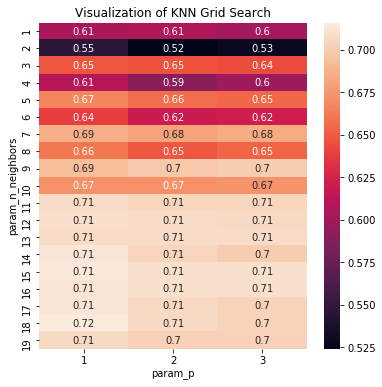

In [88]:
knn_results = pd.DataFrame(grid_knn.cv_results_)
max_scores = knn_results.groupby(['param_n_neighbors', 'param_p']).max()
max_scores = max_scores.unstack()[['mean_test_score']]
plt.figure(figsize=(6,6))
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.2g')
plt.title('Visualization of KNN Grid Search', size=12)
plt.show()

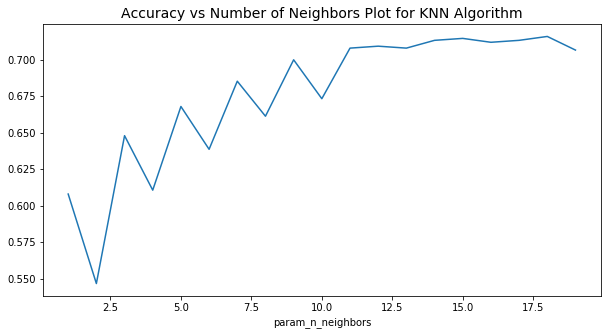

In [87]:
plt.figure(figsize=(10,5))
max_scores.mean_test_score.max(axis=1).plot()
plt.title(label='Accuracy vs Number of Neighbors Plot for KNN Algorithm', size=14)
plt.show()

### For Logistic Regression Algorithm

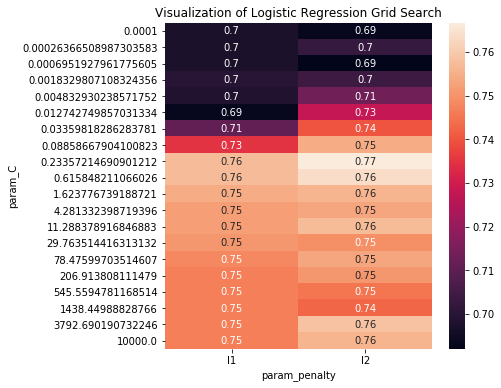

In [76]:
log_reg_results = pd.DataFrame(grid_log_reg.cv_results_)
groups = log_reg_results.groupby(['param_C', 'param_penalty'])
max_scores = groups['mean_test_score'].max()
desired_df = max_scores.unstack() 
plt.figure(figsize=(6,6))
sns.heatmap(desired_df, annot=True, fmt='.2g',yticklabels=True)
plt.title('Visualization of Logistic Regression Grid Search', size=12)
plt.show()

### For Linear SVM Algorithm
Since we have 3 hyperparameters, so we may make 3 grids to visualize their relationship

In [93]:
pd.DataFrame(grid_linear_svm.cv_results_);

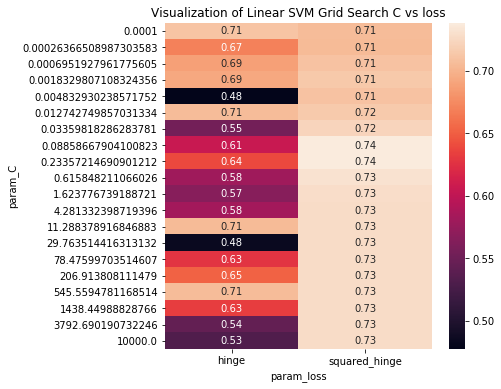

In [94]:
linear_svm_results = pd.DataFrame(grid_linear_svm.cv_results_)
groups = linear_svm_results.groupby(['param_C', 'param_loss'])
max_scores = groups['mean_test_score'].max()
desired_df = max_scores.unstack() 
plt.figure(figsize=(6,6))
sns.heatmap(desired_df, annot=True, fmt='.2g',yticklabels=True)
plt.title('Visualization of Linear SVM Grid Search C vs loss', size=12)
plt.show()

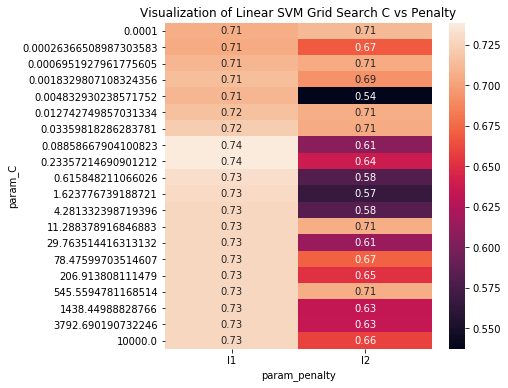

In [95]:
linear_svm_results = pd.DataFrame(grid_linear_svm.cv_results_)
groups = linear_svm_results.groupby(['param_C', 'param_penalty'])
max_scores = groups['mean_test_score'].max()
desired_df = max_scores.unstack() 
plt.figure(figsize=(6,6))
sns.heatmap(desired_df, annot=True, fmt='.2g',yticklabels=True)
plt.title('Visualization of Linear SVM Grid Search C vs Penalty', size=12)
plt.show()

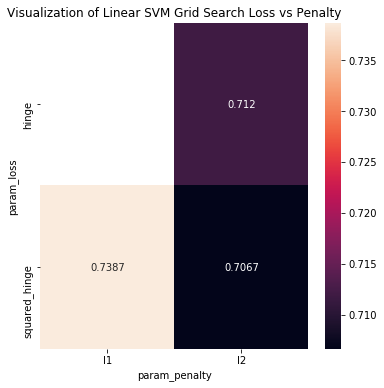

In [96]:
linear_svm_results = pd.DataFrame(grid_linear_svm.cv_results_)
groups = linear_svm_results.groupby(['param_loss', 'param_penalty'])
max_scores = groups['mean_test_score'].max()
desired_df = max_scores.unstack() 
plt.figure(figsize=(6,6))
sns.heatmap(desired_df, annot=True, fmt='.4g',yticklabels=True)
plt.title('Visualization of Linear SVM Grid Search Loss vs Penalty', size=12)
plt.show()

### Comment
since linear svm had 3 hyperparameters, so used 3 2D grids for visualization. In practice, we might go for a 3d visualization

### 1.6 Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

### Trying k fold with shuffling

In [97]:
# for knn
param_grid_knn_kfold = {'n_neighbors': np.arange(1,20,1),'p': [1,2]} 
grid_knn_kfold = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=KFold(n_splits=5, shuffle=True))
grid_knn_kfold.fit(x_trainVal, y_trainVal)
print('Maximum Cross Validation Accuracy: ',  round(grid_knn_kfold.best_score_,3))
print('Optimal Parameters: ', grid_knn_kfold.best_params_)

Maximum Cross Validation Accuracy:  0.717
Optimal Parameters:  {'n_neighbors': 17, 'p': 1}


In [98]:
# for logistic regression
param_grid_log_reg_kfold = [{'penalty' : ['l1'],    'C' : np.logspace(-4, 4, 20),    'solver':['liblinear']},
                      {'penalty' : ['l2'],    'C' : np.logspace(-4, 4, 20),    'solver':['lbfgs']}]
grid_log_reg_kfold = GridSearchCV(LogisticRegression(), param_grid=param_grid_log_reg_kfold, cv=KFold(n_splits=5, shuffle=True))
grid_log_reg_kfold.fit(x_trainVal, y_trainVal) 
print('Maximum Cross Validation Accuracy: ',  round(grid_log_reg_kfold.best_score_,4))
print('Optimal Parameters: ', grid_log_reg_kfold.best_params_)

Maximum Cross Validation Accuracy:  0.7493
Optimal Parameters:  {'C': 206.913808111479, 'penalty': 'l2', 'solver': 'lbfgs'}


In [99]:
# for linear svm, combination of l1 and hinge aren't supported in LinearSVC class
param_grid_linear_svm_kfold =  [ 
    {'penalty' : ['l1'], 'loss' : ['squared_hinge'], 'dual':[False], 'C' : np.logspace(-4, 4, 20)},
    {'penalty' : ['l2'], 'loss' : ['hinge', 'squared_hinge'], 'dual':[True], 'C' : np.logspace(-4, 4, 20)}
]
grid_linear_svm_kfold = GridSearchCV(LinearSVC(), param_grid=param_grid_linear_svm_kfold, cv=KFold(n_splits=5, shuffle=True))
grid_linear_svm_kfold.fit(x_trainVal, y_trainVal) 
print('Maximum Cross Validation Accuracy: ',  round(grid_linear_svm_kfold.best_score_,3))
print('Optimal Parameters: ', grid_linear_svm_kfold.best_params_)

Maximum Cross Validation Accuracy:  0.744
Optimal Parameters:  {'C': 0.615848211066026, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}


In [100]:
print('Test Set Accuracy of Optimal Model: ', round(grid_log_reg_kfold.score(x_test, y_test),3)) 

Test Set Accuracy of Optimal Model:  0.796


### Comments
with shuffle = True, results of cross validation are different on each run. Moreover, changing cv strategy from stratified to kfold has changed the optimal hyperparameters settings and also changed accuracy of individual models 

While previously linear svm was the winner, now logistic regression has surpassed it in terms of accuracy and gave validation accuracy of 74.9% and test set accuracy of 79.6%. Moreover, it is important to note that results are not generally reproducable and to get consistent results we have to go back to stratified k-fold or make shuffle=False

### Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

In [101]:
# for knn
param_grid_knn_kfold = {'n_neighbors': np.arange(1,20,1),'p': [1,2,3]} 
grid_knn_kfold = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn_kfold, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=5))
grid_knn_kfold.fit(x_trainVal, y_trainVal)
print('Maximum Cross Validation Accuracy: {:.3f}'.format(grid_knn_kfold.best_score_))
print('Optimal Parameters: ', grid_knn_kfold.best_params_)

Maximum Cross Validation Accuracy: 0.704
Optimal Parameters:  {'n_neighbors': 17, 'p': 1}


In [102]:
# for logistic regression
param_grid_log_reg_kfold = [{'penalty' : ['l1'],    'C' : np.logspace(-4, 4, 20),    'solver':['liblinear']},
                      {'penalty' : ['l2'],    'C' : np.logspace(-4, 4, 20),    'solver':['lbfgs']}]
grid_log_reg_kfold = GridSearchCV(LogisticRegression(), param_grid=param_grid_log_reg_kfold, 
                            cv=KFold(n_splits=5, shuffle=True, random_state=2))
grid_log_reg_kfold.fit(x_trainVal, y_trainVal) 
print('Maximum Cross Validation Accuracy: ',  round(grid_log_reg_kfold.best_score_,4))
print('Optimal Parameters: ', grid_log_reg_kfold.best_params_)

Maximum Cross Validation Accuracy:  0.7493
Optimal Parameters:  {'C': 1.623776739188721, 'penalty': 'l1', 'solver': 'liblinear'}


In [103]:
# for linear svm 
param_grid_linear_svm_kfold =  [ 
    {'penalty' : ['l1'], 'loss' : ['squared_hinge'], 'dual':[False], 'C' : np.logspace(-4, 4, 20)},
    {'penalty' : ['l2'], 'loss' : ['hinge', 'squared_hinge'], 'dual':[True], 'C' : np.logspace(-4, 4, 20)}
]
grid_linear_svm_kfold = GridSearchCV(LinearSVC(), param_grid=param_grid_linear_svm_kfold, 
                                  cv=KFold(n_splits=5, shuffle=True, random_state=np.random.seed(8)))
grid_linear_svm_kfold.fit(x_trainVal, y_trainVal) 
print('Maximum Cross Validation Accuracy: ',  round(grid_linear_svm_kfold.best_score_,4))
print('Optimal Parameters: ', grid_linear_svm_kfold.best_params_)

Maximum Cross Validation Accuracy:  0.7453
Optimal Parameters:  {'C': 0.23357214690901212, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}


In [94]:
print('Test Set Accuracy of Optimal Model: ', round(grid_log_reg.score(x_test, y_test),3)) 

Test Set Accuracy of Optimal Model:  0.7


### Comments
as expectedly, using a different random seed or random split would change the hyperparameter settings. Moreover, results of svm and logistic regression are so close that using different values of random instance, we get different validation results for each and logistic regression and linear svm compete each other for best model. While knn didn't get a lot of improvement even after doing all this random stuff.

### 1.7 Visualize the 20 most important coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.
magnitude of the coefficients of log_reg and svm is directly proportional to the importance given by the algorithm to the respective feature. SO finding top 20 coefficients would tell us which features are prominent in terms of making the final decision

In [105]:
df.head() ;

In [106]:
onehot_categorical_features = list(preprocessing.named_transformers_['onehotencoder'].get_feature_names(categorical_features))

In [107]:
ct = make_column_transformer((OneHotEncoder(), categorical_features), 
                             (StandardScaler(), continuous_features))
res = ct.fit_transform(df_data)
print(res.shape)
df_tranformed = pd.DataFrame(res, columns = onehot_categorical_features+continuous_features)
df_tranformed.head() # use it to find names of coefficient columns

(1000, 61)


,checking_status_0.0,checking_status_1.0,checking_status_2.0,checking_status_3.0,credit_history_0.0,credit_history_1.0,credit_history_2.0,credit_history_3.0,credit_history_4.0,purpose_0.0,...,own_telephone_1.0,foreign_worker_0.0,foreign_worker_1.0,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869


In [108]:
def coeff_visualizer(estimator, transformed_feature_names, plot_title='Model Coefficients Visualization', num_of_coeff=20, figsize=(20,10)):
        coeff = abs(np.ravel(estimator.coef_))
        num_of_coeff = num_of_coeff
        sort_indices = np.argsort(coeff) # return indices that would sort an array
        less_imp_coeff = max(sort_indices)-num_of_coeff
        b = sort_indices > less_imp_coeff
        transformed_features = transformed_feature_names

        imp_coeff = []
        imp_features = []
        for i,j in enumerate(b):
            if j==True:
                imp_coeff.append(coeff[i])
                imp_features.append(transformed_features[i])

        a = zip(imp_coeff, imp_features)
        df_imp_coeff = pd.DataFrame(a, columns=['imp_coeff', 'feature_names'])
        df_imp_coeff = df_imp_coeff.sort_values('imp_coeff', ascending=False)
    
        plt.figure(figsize=figsize)
        sns.barplot(x=df_imp_coeff['imp_coeff'], y=df_imp_coeff['feature_names'], data=df_imp_coeff)
        plt.title(plot_title, size=20)
        plt.show()

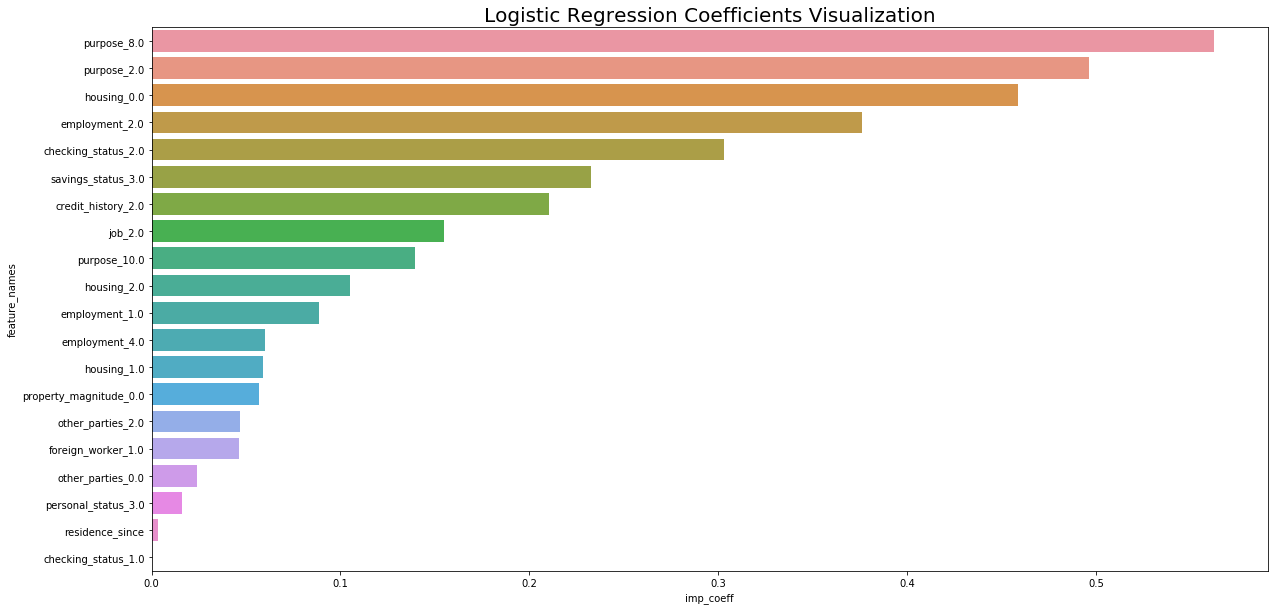

In [109]:
coeff_visualizer(estimator = grid_log_reg.best_estimator_, transformed_feature_names = df_tranformed.keys(), 
                 plot_title='Logistic Regression Coefficients Visualization')

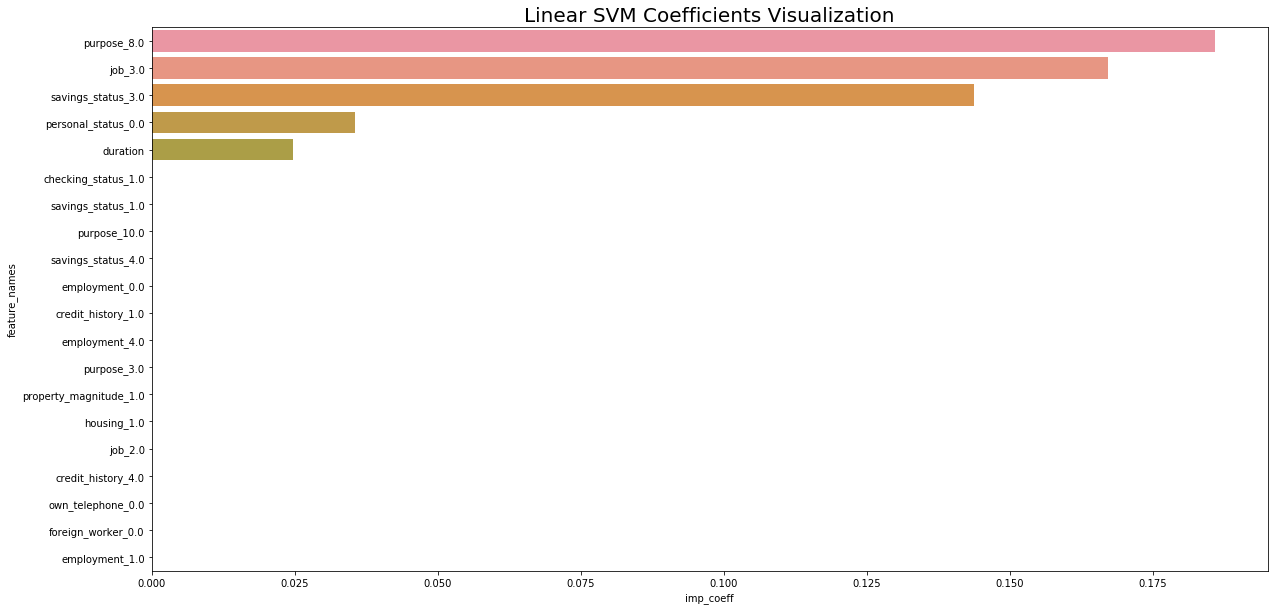

In [111]:
coeff_visualizer(grid_linear_svm.best_estimator_, transformed_feature_names = df_tranformed.keys(),
                 plot_title='Linear SVM Coefficients Visualization')

### Comment
It is quite surprising to see that linear svm is giving weightage to only 5 features and still reaching above 75% accuracy. One of the reasons of other coefficients being zero is that the optimal model for linear svm uses L1 penalty due to which coefficient matrix becomes sparse.

# Conclusion
In this exercise, we compared knn, logistic regression and linear svm for classification of 'credit-g' dataset. We first of all imported the dataset and done preprocessing of categorical variables using one hot encoding by utilizing the concept of column tranformer in scikit learn. We found that preprocessing of contiuous variables (i.e. scaling) didn't effect the performance of logistic regression model, while improved the accuracies of svm and knn model. Then we utilized the gridsearchCV module in scikit learn and found the optimal hyperparameter choices for each model. We also visualized the results of gridsearch using 1d plot and 2d heatmaps. We then compared the effect of using kfold (with shuffle) cross validation instead of stratified CV and found that using a different random seed or different shuffle make the results non-reproducable and lead to different hyperparameter choices in different iterations. Moreover, logistic regression and linear-svm were the best performing models with test set accuracy of about 75% in all these scenerios. At the end, we visualized the top features (coefficients) of these two models and surprisingly found that due to L1 penalty, linear svm was only relying on 5 features to make a prediction